# Series-to-Series Derivation

Numpy has a class called [Chebyshev](https://numpy.org/doc/2.2/reference/generated/numpy.polynomial.chebyshev.Chebyshev.html), and this class, like other polynomial classes, has a `.deriv()` function. I got curious and started digging in to it and learned that, analogous to [power rule](https://en.wikipedia.org/wiki/Power_rule) for power series, [there is a rule for taking the derivative in terms of a Chebyshev series](https://scicomp.stackexchange.com/questions/44939/chebyshev-series-derivative-in-terms-of-coefficients).

Why and how it works is explored in the stackexchange post linked above and in [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf). More pertinent to this code is that I opened [Issue #16](https://github.com/pavelkomarov/spectral-derivatives/issues/16) to explore the implications of the newfound fact that much of `math.pdf` and [Trefethen himself](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8) are overcomplicating taking derivatives with the Chebyshev basis. We can obviate a lot of steps, and it's helpful to see in code.

0 1.3650616181465713e-29 4.4070488222061286e-31 
1 2.231517457707218e-23 2.2311914575790083e-23 2.223807875667404e-23
2 1.5711014273256574e-16 1.5713090100300078e-16 1.445672398539592e-16
3 3.8785528491379313e-10 3.878568041725779e-10 3.2235761308183e-10
4 7084737.654589344 7084737.654580043 7084681.552949228


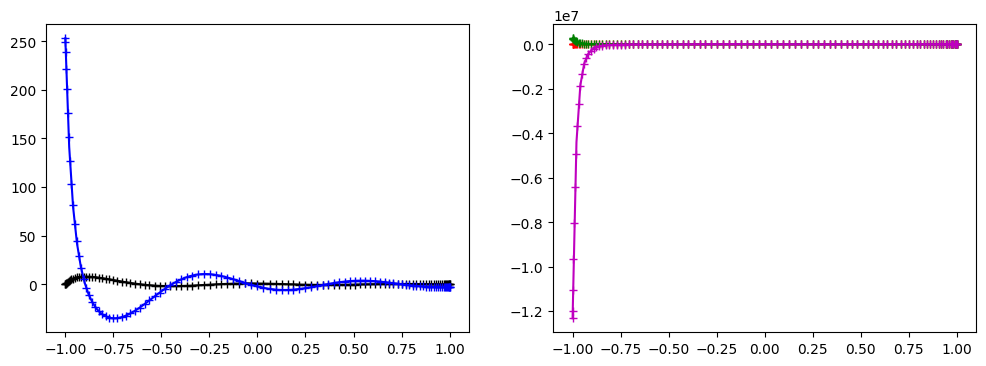

In [36]:
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
from matplotlib import pyplot
from scipy.fft import dct, dst
from specderiv import cheb_deriv

N = 100

x_n = np.cos(np.arange(N+1) * np.pi / N)
x = np.linspace(-1, 1, 100)

y = lambda x: np.sin(8*(x+1))/((x + 1.1)**(3/2))# + np.random.randn(*x.shape)*0.05
dy = lambda x: ((8.8 + 8*x)*np.cos(8*(x+1)) - 1.5*np.sin(8*(x+1)))/((x + 1.1)**(5/2))
d2y = lambda x: ((-26.4 - 24*x)*np.cos(8 + 8*x) + (-73.69 + (-140.8 - 64*x)*x)*np.sin(8 + 8*x))/((1.1 + x)**(7/2))
d3y = lambda x: ((-582.472 + x*(-1768.56 + (-1689.6 - 512*x)*x))*np.cos(8 + 8*x) + (335.355 + x*(633.6 + 288.*x))*np.sin(8 + 8*x))/((1.1 + x)**(9/2))
d4y = lambda x: ((3626.83 + x*(10731.4 + x*(10137.6 + 3072*x)))*np.cos(8 + 8*x) + (4313.62 + x*(18639.1 + x*(28297. + x*(18022.4 + 4096*x))))*np.sin(8 + 8*x))/((1.1 + x)**(11/2))

#y = lambda x: np.exp(x) * np.sin(5*x) + np.random.randn(*x.shape)*0.05
#dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
#d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
#d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
#d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

y_n = y(x_n)
Y_k = dct(y_n, 1)
a_k = np.zeros(Y_k.shape) # make Chebyshev coefficients from DCT coefficients
a_k[0] = Y_k[0]/(2*N); a_k[N] = Y_k[N]/(2*N) # because first and last DCT coefficients are outside the sum
a_k[1:N] = Y_k[1:N]/N # In IDCT-I we divide by 2N, and all the middle terms have a 2 in the numerator, the one next to the sum
cheb = Chebyshev(a_k) # This class' deriv function works in O(N)
# No mapping back to chebyshev domain. No worrying about endpoint formulas.

def L2(w, v):
    """calculate L2 error squared"""
    return np.mean((w - v)**2)

y_n_primes = []
for nu,dy_ in enumerate([y, dy, d2y, d3y, d4y]):
    dcheb = cheb.deriv(nu) # O(nu * N) instead of O(N + nu^2 + nu * N)

    # Evaluating cheb(x) uses `chebval`, which is based on the recurrence formula, which works in O(cN), where c is the
    # number of coefficients, which will be another N in this case. We can avoid this O(N^2) with an inverse transform,
    # since our sample points are the Chebyshev points. We can construct the Y_k' necessary for such a transform from
    # the Chebyshev coefficients.
    a_k_prime = np.concatenate((dcheb.coef, [0]*nu)) # always len N so we get N samples back after inverse transform
    Y_k_prime = np.zeros(a_k_prime.shape)
    Y_k_prime[0] = a_k_prime[0]*2*N; Y_k_prime[N] = a_k_prime[N]*2*N
    Y_k_prime[1:N] = a_k_prime[1:N]*N
    
    y_n_primes.append( dct(Y_k_prime, 1)/(2*N) ) # This is the O(N log N) way, via inverse transform

    dy_n = dy_(x_n)
    print(nu, L2(dy_n, dcheb(x_n)), L2(dy_n, y_n_primes[-1]), "" if nu == 0 else L2(dy_n, cheb_deriv(y_n, x_n, nu)))

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y(x), 'k')
axes[0].plot(x_n, y_n_primes[0], 'k+')
axes[0].plot(x, dy(x), 'b')
axes[0].plot(x_n, y_n_primes[1], 'b+')
axes[1].plot(x, d2y(x), 'r')
axes[1].plot(x_n, y_n_primes[2], 'r+')
axes[1].plot(x, d3y(x), 'g')
axes[1].plot(x_n, y_n_primes[3], 'g+')
axes[1].plot(x, d4y(x), 'm')
axes[1].plot(x_n, y_n_primes[4], 'm+');


We can actually do the DCT-II with this method also, because we can reach the same coefficients simply:

In [2]:
x_nII = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))

y_nII = y(x_nII)
Y_kII = dct(y_nII[1:-1], 2)
Y_kII[0] /= 2 # because first element of DCT-III is outside the sum
Y_kII /= N+1 # IDCT-II has division by N+1

assert np.allclose(Y_k, Y_kII)

cheb = Chebyshev(Y_kII)
cheb_1 = cheb.deriv(1) # O(nu * N) instead of O(N + nu^2 + nu * N + N log N)
cheb_2 = cheb.deriv(2)
cheb_3 = cheb.deriv(3)
cheb_4 = cheb.deriv(4)

print("0", np.mean((y_nII - cheb(x_nII))**2))
print("1", np.mean((dy(x_nII) - cheb_1(x_nII))**2), np.mean((dy(x_nII) - cheb_deriv(y_nII, x_nII, 1, dct_type=2))**2))
print("2", np.mean((d2y(x_nII) - cheb_2(x_nII))**2), np.mean((d2y(x_nII) - cheb_deriv(y_nII, x_nII, 2, dct_type=2))**2))
print("3", np.mean((d3y(x_nII) - cheb_3(x_nII))**2), np.mean((d3y(x_nII) - cheb_deriv(y_nII, x_nII, 3, dct_type=2))**2))
print("4", np.mean((d4y(x_nII) - cheb_4(x_nII))**2), np.mean((d4y(x_nII) - cheb_deriv(y_nII, x_nII, 4, dct_type=2))**2))

0 3.906479119716537e-24
1 566219.1745550843 566219.1745550843
2 2.6220943503579212e-14 2.6220860666289068e-14
3 2.1545138192240087e-10 2.1544799361755951e-10
4 8.747607419613032e-07 8.745764380667108e-07
